In [ ]:
from tensorflow.keras.layers import  Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

In [ ]:
# 하이퍼 파리미터 설정
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [ ]:
def sampling(args: tuple):
    # 튜플로 매개변수를 감싼다.
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### 784 > 256 > 2(인데 평균, 분산 2개 2개로) >

In [ ]:
# 인코더 입력
x = Input(shape=(original_dim,), name="input") # 784 차원의 입력층


# 중간 층
h = Dense(intermediate_dim, activation='relu', name="encoding")(x) # 100차원의 중간층


# 잠재 공간의 평균을 정의
z_mean = Dense(latent_dim, name="mean")(h)


# 잠재 공간의 로그 분산을 정의
z_log_var = Dense(latent_dim, name="log-variance")(h)


# sampling 함수에 입력으로 평균, 로그분산을 넣어서 출력으로 2차원을 냄
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# 케라스 모델로 인코더를 정의
encoder = Model(x, [z_mean, z_log_var, z], name="encoder") # 입력으로 x 출력으로 3개(평균, 분산으로 분포를 나타냄)


# 인코더 구조를 출력
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

### 2 > 256 > 784

In [ ]:
input_decoder = Input(shape=(latent_dim), name="deoder_input")

decoder_h = Dense(intermediate_dim, activation="relu", name="decoder_h")(input_decoder)

x_decoded = Dense(original_dim, activation="sigmoid", name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name = "decoder")

In [ ]:
# 인코더 출력을 디코더에 사용
output_combined = decoder(encoder(x)[2]) 

vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis=-1)

# 이렇게 vae의 목적함수에 더하여 두 개의 목표를 갖는다.
vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer="rmsprop", loss = "binary_crossentropy")

#### 이미지 공통 전처리 : 정규화, 소수로 바꾸는 것

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 10s 15ms/step - loss: 0.2437
Epoch 2/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2178
Epoch 3/50
600/600 [==============================] - 9s 16ms/step - loss: 0.2125
Epoch 4/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2092
Epoch 5/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2073
Epoch 6/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2059
Epoch 7/50
600/600 [==============================] - 10s 16ms/step - loss: 0.2049
Epoch 8/50
600/600 [==============================] - 11s 18ms/step - loss: 0.2041
Epoch 9/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2033
Epoch 10/50
600/600 [==============================] - 10s 16ms/step - loss: 0.2026
Epoch 11/50
600/600 [==============================] - 12s 19ms/step - loss: 0.2020
Epoch 12/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2013
Epoch 13

# 모든 테스트 셋을 잠재 공간으로 2차원 투영

- 2차원 잠재 공간 그래프를 보여줌 = 잠재 공간이 이런 모양이다.
- 레이블이 잠재 공간에서 잘 구분되어 있으면 좋은 잠재 공간이다.

 

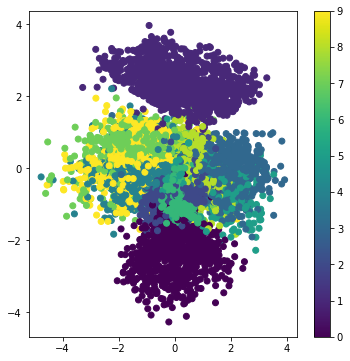

In [ ]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

### 잠재 공간 값을 0.15씩 바꾸면 1에서 9로 생성되는 이미지가 바뀜

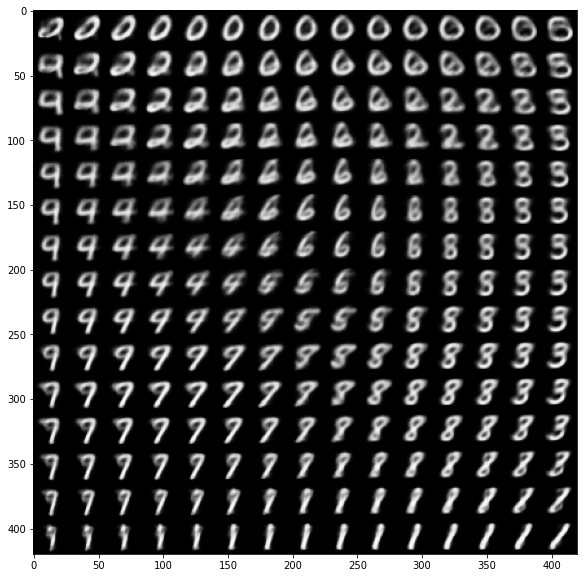

In [ ]:
from scipy.stats import norm


# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()